## Birds Species Image Classifier

In [28]:
#Needed for EDA in Google colab
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#Stage 1: EDA

In [78]:
#Read Data and Store it in a dataframe
# Generate data paths with labels
#Use your own dataset path in Google drive
data_dir = '/content/drive/MyDrive/Bird-dataset'
Image_Data_Path = data_dir + '/train/'
names = ['ID', 'class id', 'filepaths', 'labels', 'data set']
train_df = pd.read_csv(data_dir + '/birds.csv')
filepaths = []
labels = []

folds = os.listdir(Image_Data_Path)
for fold in folds:
    foldpath = os.path.join(Image_Data_Path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [59]:
#EDA Q1:How is the data distribution
df.head(5)

filepaths           labels
0  /content/drive/MyDrive/Bird-dataset/train/ABBO...  ABBOTTS BABBLER
1  /content/drive/MyDrive/Bird-dataset/train/ABBO...  ABBOTTS BABBLER
2  /content/drive/MyDrive/Bird-dataset/train/ABBO...  ABBOTTS BABBLER
3  /content/drive/MyDrive/Bird-dataset/train/ABBO...  ABBOTTS BABBLER
4  /content/drive/MyDrive/Bird-dataset/train/ABBO...  ABBOTTS BABBLER

In [60]:
df.tail(5)

filepaths      labels
84630  /content/drive/MyDrive/Bird-dataset/train/ZEBR...  ZEBRA DOVE
84631  /content/drive/MyDrive/Bird-dataset/train/ZEBR...  ZEBRA DOVE
84632  /content/drive/MyDrive/Bird-dataset/train/ZEBR...  ZEBRA DOVE
84633  /content/drive/MyDrive/Bird-dataset/train/ZEBR...  ZEBRA DOVE
84634  /content/drive/MyDrive/Bird-dataset/train/ZEBR...  ZEBRA DOVE

In [79]:
#EDA Q2:Are there labels available for the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84635 entries, 0 to 84634
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  84635 non-null  object
 1   labels     84635 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [ ]:
#Test Dataset Exploration

In [74]:
Image_Data_Path = data_dir + '/test/'
test_df = pd.read_csv(data_dir + '/birds.csv')
test_df.head()

class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI

In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89885 entries, 0 to 89884
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class id         89885 non-null  float64
 1   filepaths        89885 non-null  object 
 2   labels           89885 non-null  object 
 3   data set         89885 non-null  object 
 4   scientific name  89885 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.4+ MB


# Observations


1. The dataset is divided into a subset of  84635 train images and 2625 test images.
2. The train and test subsets have image location shown as the filepath column/attribute in the dataset
3. There are 5 columns in total. class_id, filepath, class labels ,data set and scientific name valid status of the dataset.  


### Exploring Data Columns in dataset
### Label Group

In [80]:
labels_df = train_df[['class id', 'labels']].groupby(['labels']).count().reset_index()
labels_df.columns = ['class id','count']
labels_df =labels_df.sort_values(by =['count'],ascending = False)
print(labels_df)

                    class id  count
434             RUFOUS TREPE    273
291              HOUSE FINCH    258
374                 OVENBIRD    243
184         D-ARNAUDS BARBET    243
41     ASIAN GREEN BEE EATER    230
..                       ...    ...
416        RED TAILED THRUSH    140
363      NORTHERN RED BISHOP    140
25         AMETHYST WOODSTAR    140
382  PATAGONIAN SIERRA FINCH    140
453             SNOWY PLOVER    140

[525 rows x 2 columns]


In [81]:
print('Number of unique labels: ', labels_df.shape[0])

Number of unique labels:  525


Text(0.5, 1.0, 'Number of images in the same label for each label/class')

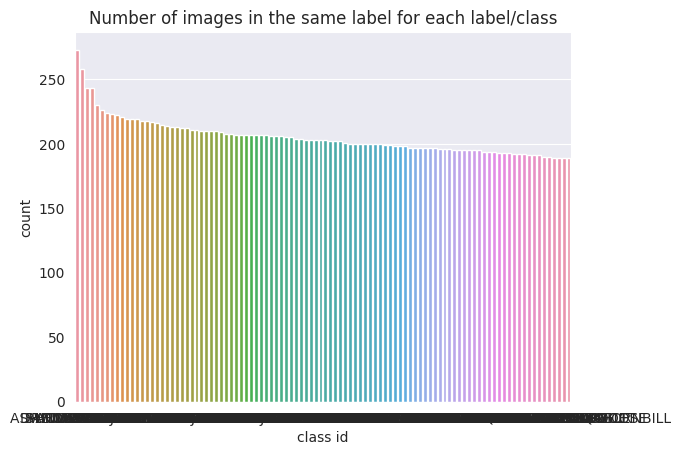

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=labels_df['class id'][:100], y =labels_df['count'][:100] )
plt.title("Number of images in the same label for each label/class")

##Observations


1.   From the above information, we can see that the images in train subset belong to 525 birds species(class labels).
2. Class label 434) has highest number of images (273 images) for  Rufous Trepe.
3. Class label 453  has least number of images (140 images) for Snow Plober.

4. This problem can be solved as a classification problem to automatically classify bird images into 100 different classes.

5. In the first stage of my study for this capstone project, I will investigate a two-class image classification problem using first Two classes in alphabetical order in the dataset:( ABBOTTS BABBLER (163 images) vs. ABBOTTS BOOBY (180 images)


In [35]:
#EDA 3: How much data can be used for training, validation and testing?
#Split dataframe into train, valid, and test
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [36]:
# EDA Q4: Can we visualise the data?
#Create image data generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 67708 validated image filenames belonging to 525 classes.
Found 10156 validated image filenames belonging to 525 classes.
Found 6771 validated image filenames belonging to 525 classes.


### Analysing images for two class image classification problem

In [37]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

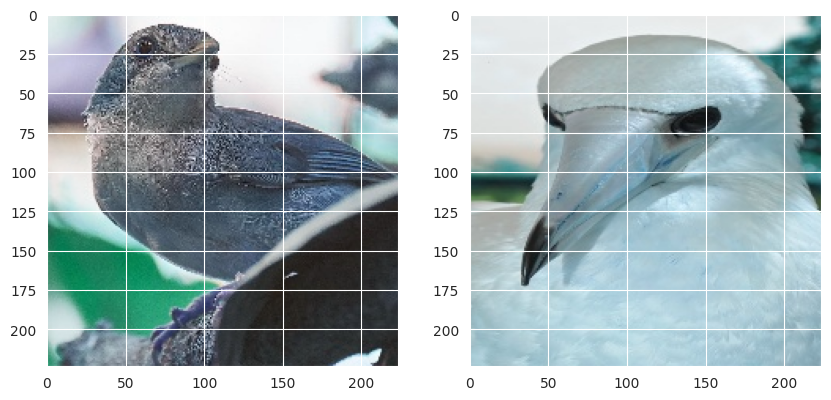

In [38]:
#Read and Display Images

img_path_1 = '/content/drive/MyDrive/Bird-dataset/train/ABBOTTS BABBLER/001.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/drive/MyDrive/Bird-dataset/train/ABBOTTS BOOBY/001.jpg'
img_2 = cv2.imread(img_path_2)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img_1)
plt.subplot(122)
plt.imshow(img_2);

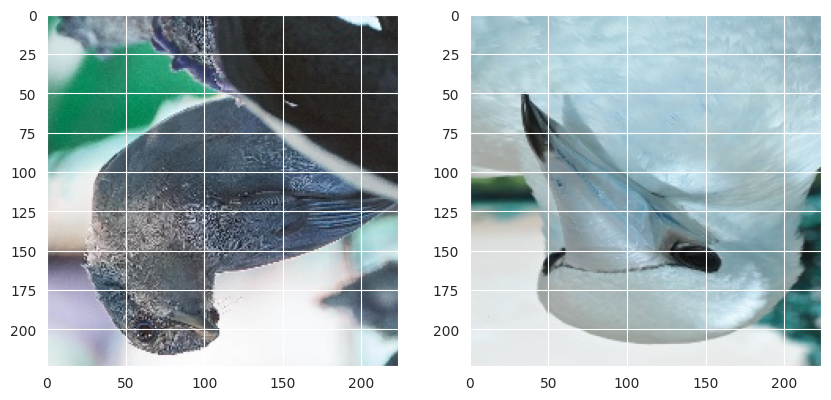

In [39]:
#Basic image manipulation (rotating/flipping)
flip_img_1=cv2.flip(img_1,0) # vertical flip
flip_img_2=cv2.flip(img_2,0) # vertical flip

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(flip_img_1)
plt.subplot(122)
plt.imshow(flip_img_2)

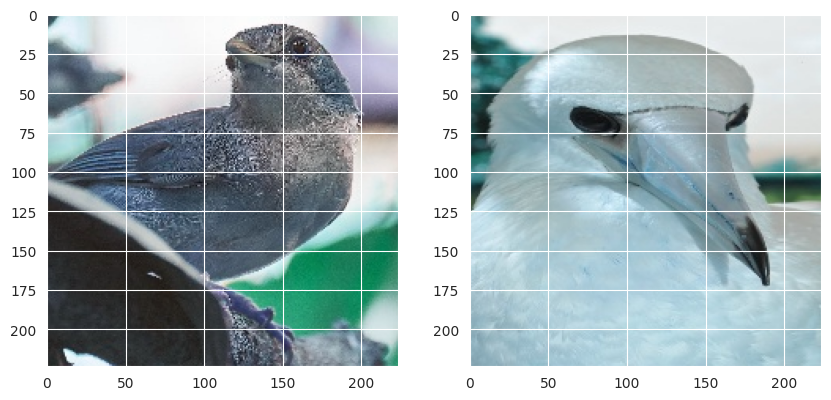

In [40]:
#horizontal flip
flip_img_1=cv2.flip(img_1,1) # horizontal flip
flip_img_2=cv2.flip(img_2,1) # horizontal flip

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(flip_img_1)
plt.subplot(122)
plt.imshow(flip_img_2)

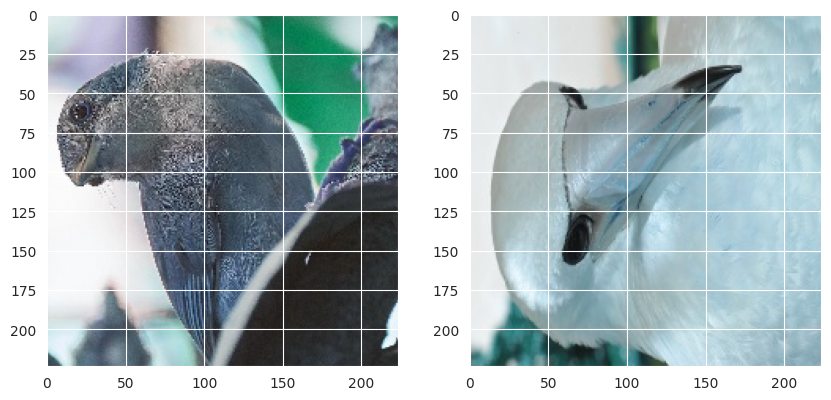

In [41]:
#transpose

transp_img_1=cv2.transpose(img_1,1) # transpose
transp_img_2=cv2.transpose(img_2,1) # transpose

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(transp_img_1)
plt.subplot(122)
plt.imshow(transp_img_2)


#Exracting Features in Visual Exploratory Data Analysis for visual model building
Features are image properties at locations that are used for computer based visual model development. Computer interprets the images based on these feature based Visual models. Some of the feature extraction techniques being attempted here are:
1. Making sense of images in presence of noise.
2. Extracting edges and Corners.
3. Understanding the impact of lighting and illumination artefacts.

Q5 EDA- How discriminative are the salient features such as edges and corners for images corresponding to each class
Conversion to Gray scale image needed for extracting edges and corners




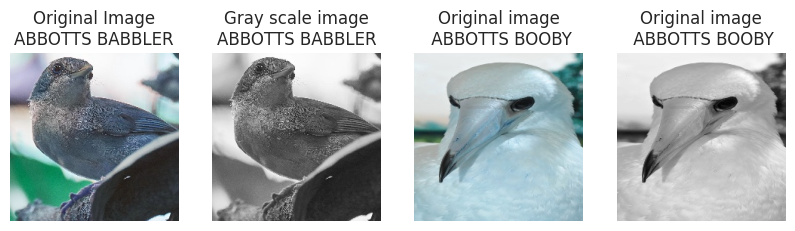

In [42]:
#Conversion to Gray scale image needed for pre-processing
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
%matplotlib inline


fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(10, 10))

ax1.imshow(img_1)
ax1.set_title('Original Image\nABBOTTS BABBLER')
ax1.set_axis_off()

ax2.imshow(skic.rgb2gray(img_1), cmap ='gray')
ax2.set_title('Gray scale image\nABBOTTS BABBLER')
ax2.set_axis_off()

ax3.imshow(img_2)
ax3.set_title('Original image\n ABBOTTS BOOBY')
ax3.set_axis_off()


ax4.imshow(skic.rgb2gray(img_2),cmap = 'gray')
ax4.set_title('Original image\n ABBOTTS BOOBY')
ax4.set_axis_off()




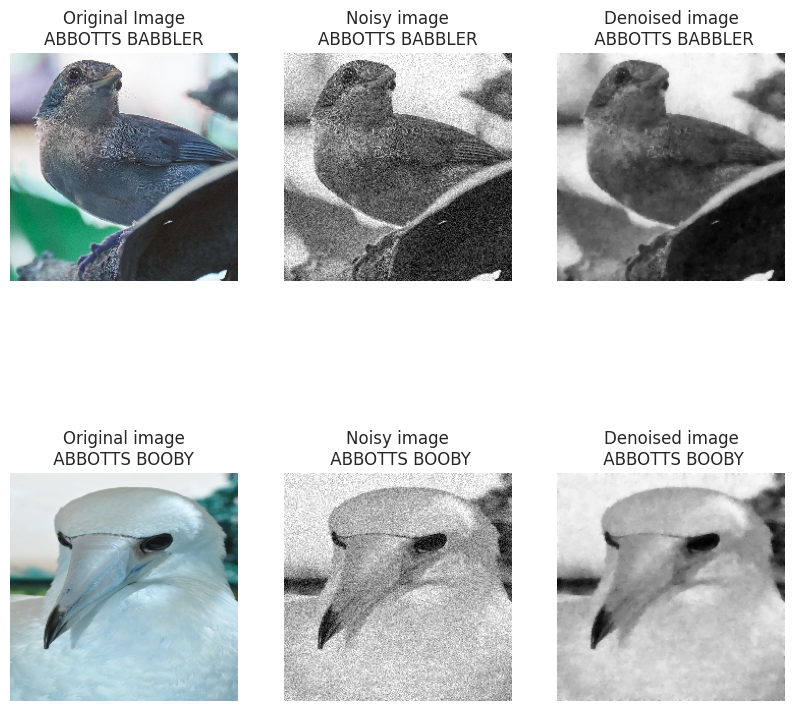

In [43]:
# We add Gaussian noise and denoise using denoise_tv_bregman approach
#for img_1 and img_2
img_1_n = sku.random_noise(skic.rgb2gray(img_1))
img_1_d = skimage.restoration.denoise_tv_bregman(img_1_n, 5.)

img_2_n = sku.random_noise(skic.rgb2gray(img_2))
img_2_d = skimage.restoration.denoise_tv_bregman(img_2_n, 5.)


fig, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(ncols=3,nrows=2,figsize=(10, 10))

ax1.imshow(img_1)
ax1.set_title('Original Image\nABBOTTS BABBLER')
ax1.set_axis_off()

ax2.imshow(img_1_n, cmap ='gray')
ax2.set_title('Noisy image\nABBOTTS BABBLER')
ax2.set_axis_off()

ax3.imshow(img_1_d, cmap = 'gray')
ax3.set_title('Denoised image\n ABBOTTS BABBLER')
ax3.set_axis_off()

ax4.imshow(img_2)
ax4.set_title('Original image\n ABBOTTS BOOBY ')
ax4.set_axis_off()

ax5.imshow(img_2_n, cmap ='gray')
ax5.set_title('Noisy image\n ABBOTTS BOOBY')
ax5.set_axis_off()

ax6.imshow(img_2_d, cmap = 'gray')
ax6.set_title('Denoised image\n ABBOTTS BOOBY')
ax6.set_axis_off()

# Noise reduction using Gaussian Blur
Noise reduction usually involves blurring/smoothing an image using a Gaussian kernel. The width of the kernel (d)  determines the amount of smoothing. Try with d=3 or d=6


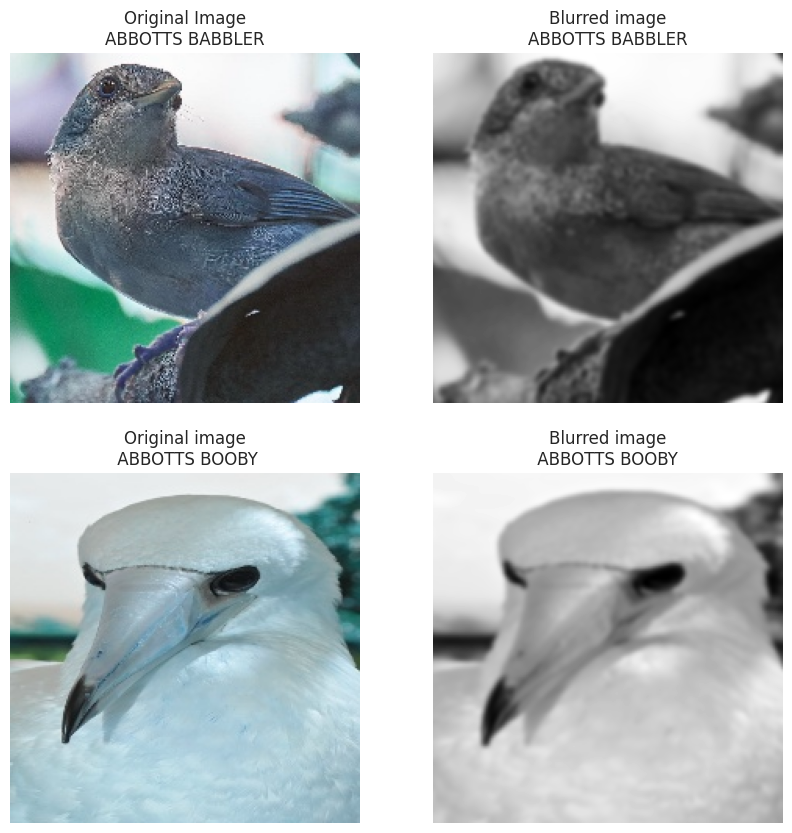

In [44]:
d=3
img_1_blur3 = cv2.GaussianBlur(skic.rgb2gray(img_1), (2*d+1, 2*d+1), -1)[d:-d,d:-d]
img_2_blur3 = cv2.GaussianBlur(skic.rgb2gray(img_2), (2*d+1, 2*d+1), -1)[d:-d,d:-d]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(10, 10))

ax1.imshow(img_1)
ax1.set_title('Original Image\nABBOTTS BABBLER')
ax1.set_axis_off()

ax2.imshow(img_1_blur3, cmap ='gray')
ax2.set_title('Blurred image\nABBOTTS BABBLER')
ax2.set_axis_off()

ax3.imshow(img_2)
ax3.set_title('Original image\n ABBOTTS BOOBY')
ax3.set_axis_off()

ax4.imshow(img_2_blur3, cmap = 'gray')
ax4.set_title('Blurred image\n ABBOTTS BOOBY ')
ax4.set_axis_off()


# Edge detection
Edge is the final image processing technique for exploring the visual data.

Edge detection functions as a building block for building computer based detection models. Sobel's edge detector is one of the first truly successful edge detection (enhancement) technique and that involves convolution processing at its core.  

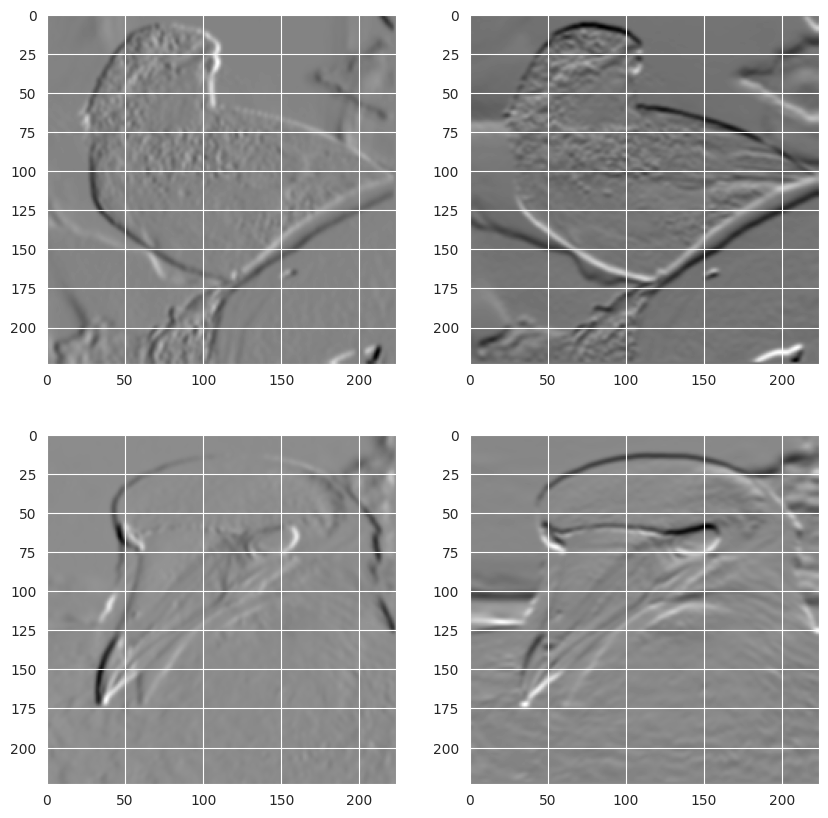

In [45]:
#Sobel edge detector
#edge detector works on gray scale images
sobel_img_1=cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
sobel_img_2=cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

sobelx_img_1 = cv2.Sobel(sobel_img_1,cv2.CV_64F,1,0,ksize=9)
sobely_img_1 = cv2.Sobel(sobel_img_1,cv2.CV_64F,0,1,ksize=9)

sobelx_img_2 = cv2.Sobel(sobel_img_2,cv2.CV_64F,1,0,ksize=9)
sobely_img_2 = cv2.Sobel(sobel_img_2,cv2.CV_64F,0,1,ksize=9)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sobelx_img_1, cmap = 'gray')
plt.subplot(222)
plt.imshow(sobely_img_1, cmap = 'gray')
plt.subplot(223)
plt.imshow(sobelx_img_2, cmap = 'gray')
plt.subplot(224)
plt.imshow(sobely_img_2, cmap = 'gray')

# Corner detectors
If you think of edges as being lines, then corners are an obvious choice for features as they represent the intersection of two lines. One of the earlier corner detectors was introduced by Harris, and it is still a very effective corner detector that gets used quite a lot: it's reliable and it's fast.

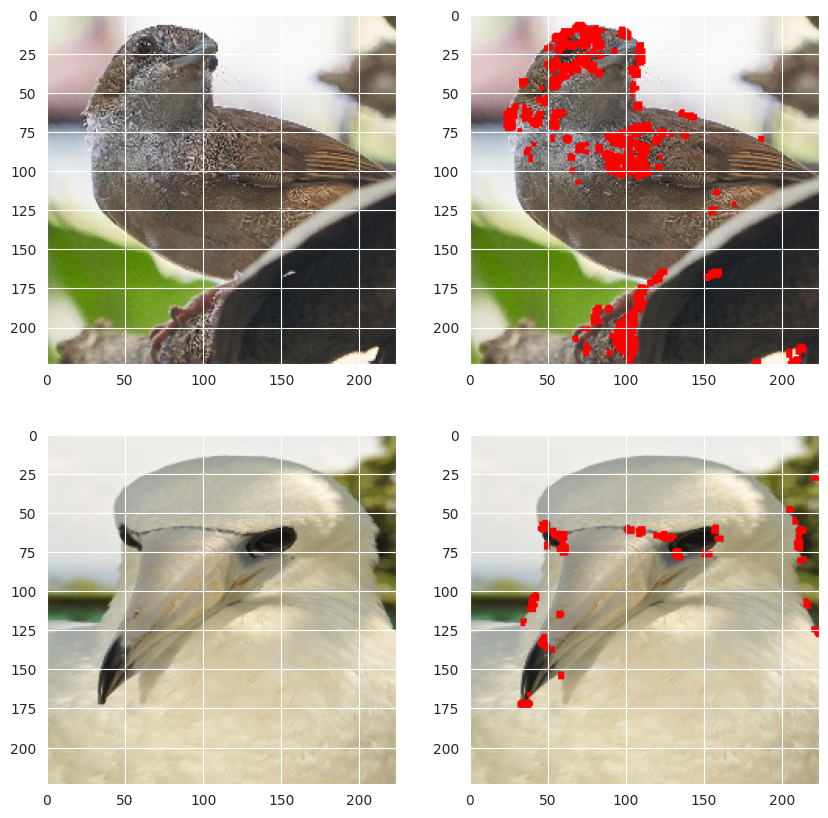

In [46]:
#detecting corners for  image_1
harris_1=img_1.copy()
#greyscale it
gray = cv2.cvtColor(harris_1,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
blocksize=4 #
kernel_size=3 # sobel kernel: must be odd and fairly small
# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold
#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_1[dst>0.01*dst.max()]=[0,0,255]

#detecting corners for image_2
harris_2=img_2.copy()
#greyscale it
gray = cv2.cvtColor(harris_2,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
blocksize=4 #
kernel_size=3 # sobel kernel: must be odd and fairly small
# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold
#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_2[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.imshow(cv2.cvtColor(harris_1, cv2.COLOR_BGR2RGB))
plt.subplot(223)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.subplot(224)
plt.imshow(cv2.cvtColor(harris_2, cv2.COLOR_BGR2RGB))


# Understanding illumination and lighting artefacts by examining the camera effects/exposure of an image


In [47]:
import skimage.exposure as skie
%matplotlib inline

In [48]:
def show(img):
    # Display the image.
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(12, 3))

    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()

    # Display the histogram.
    ax2.hist(img.ravel(), lw=0, bins=256)
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])

    plt.show()

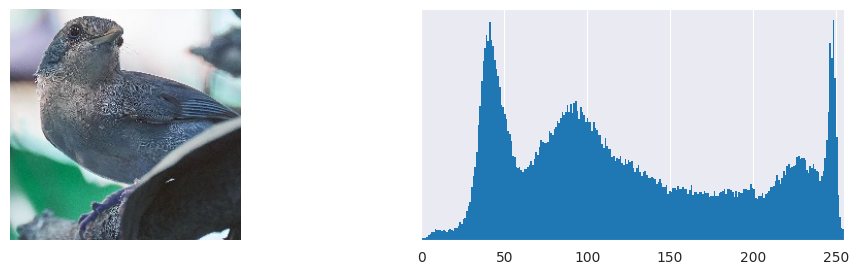

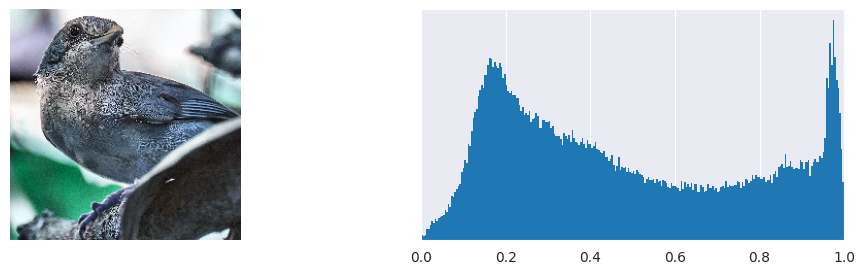

In [49]:
show(img_1)
show(skie.equalize_adapthist(img_1))

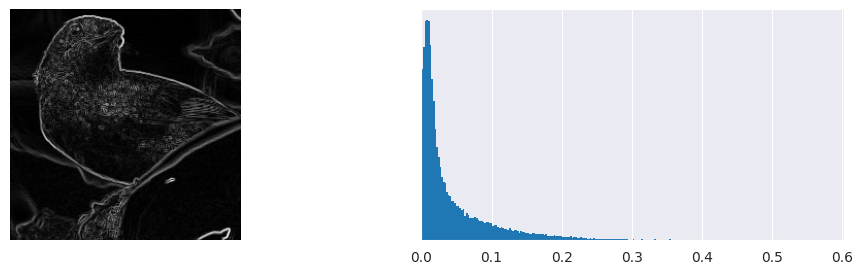

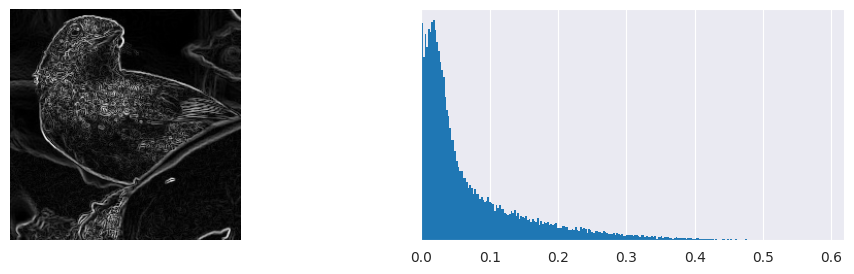

In [50]:
img = skic.rgb2gray(img_1)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_1))
sobimg_heq = skif.sobel(img)
show(sobimg_heq)

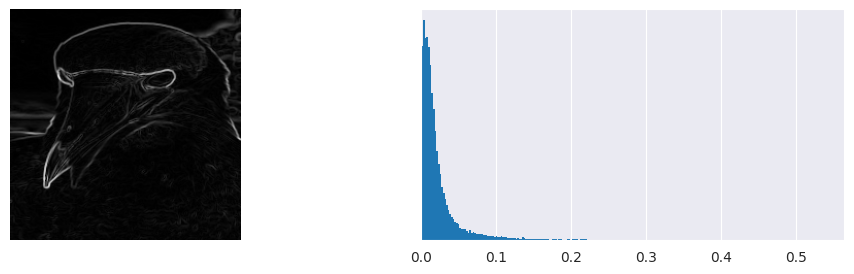

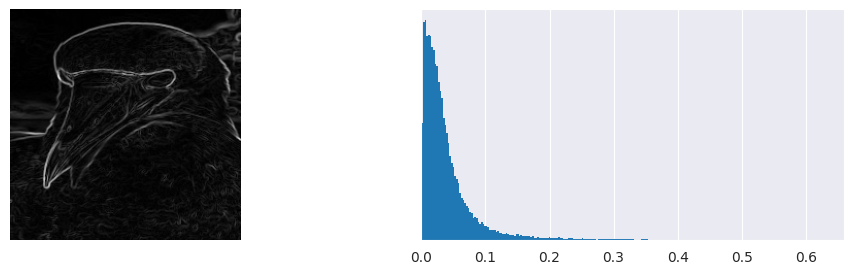

In [51]:
img = skic.rgb2gray(img_2)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_2))
sobimg_heq = skif.sobel(img)
show(sobimg_heq)

In [52]:
#EDA Q6: How does the samples from the training subset look like ?

g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.